In [2]:
from ptracking.database import cursor

# Extract the pre-processed text from the database
with cursor() as cur:
    cur.execute("SELECT petition_id, processed_content, signatures FROM petition WHERE state = 'closed'")
    content = cur.fetchall()

processed_text = [list(filter(lambda x: len(x)>3,text)) for _, text, _ in content]

In [7]:
import gensim.corpora as corpora
from gensim.models import TfidfModel

dictionary = corpora.Dictionary(processed_text)

# Create a separate corpus for TFIDF so we can filter out low value words
tfidf_corpus = [dictionary.doc2bow(words) for words in processed_text]
tfidf = TfidfModel(tfidf_corpus, dictionary)

#filter low value words TODO find a good parameter value
low_value = 0.1
petition_dict = {}

# Here we create a new corpus for LDA with the low value words removed from each documents BoW.
lda_corpus = []
for petition_id, text, signatures in content:
    bow = dictionary.doc2bow(text)
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    new_bow = [b for b in bow if b[0] not in low_value_words]
    lda_corpus.append(new_bow)
    petition_dict[petition_id] = (new_bow, signatures)

In [8]:
from gensim.models import LdaMulticore, CoherenceModel
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = LdaMulticore(corpus=lda_corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        alpha=0.1,
                        eta='auto')
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.016*"student" + 0.015*"child" + 0.010*"parent" + 0.006*"service" + '
  '0.006*"work" + 0.005*"support" + 0.005*"family" + 0.005*"school" + '
  '0.004*"home" + 0.004*"worker"'),
 (1,
  '0.008*"student" + 0.006*"leave" + 0.006*"school" + 0.005*"test" + '
  '0.004*"university" + 0.004*"support" + 0.004*"public" + 0.003*"product" + '
  '0.003*"time" + 0.003*"plastic"'),
 (2,
  '0.014*"school" + 0.014*"child" + 0.007*"work" + 0.006*"health" + '
  '0.005*"student" + 0.004*"brexit" + 0.004*"mental" + 0.004*"right" + '
  '0.003*"vote" + 0.003*"referendum"'),
 (3,
  '0.012*"child" + 0.007*"school" + 0.005*"test" + 0.004*"home" + '
  '0.004*"travel" + 0.004*"sentence" + 0.004*"increase" + 0.004*"life" + '
  '0.004*"business" + 0.003*"rate"'),
 (4,
  '0.006*"school" + 0.005*"family" + 0.005*"care" + 0.005*"covid" + '
  '0.004*"home" + 0.004*"public" + 0.004*"cancer" + 0.004*"help" + '
  '0.004*"national" + 0.004*"food"'),
 (5,
  '0.018*"child" + 0.008*"public" + 0.005*"police" + 0.005*"

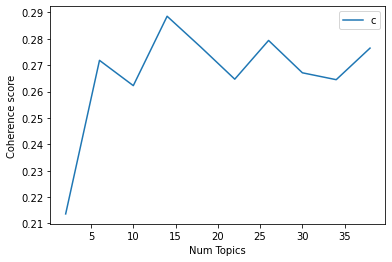

In [6]:
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=lda_corpus, texts=processed_text, start=2, limit=40, step=4)

# Show graph
limit=40 
start=2
step=4
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [9]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(lda_model, lda_corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.001049 -0.040629       1        1  14.545905
5     -0.051288 -0.003865       2        1  11.985513
2      0.009222 -0.008643       3        1  10.157602
9      0.075283  0.030906       4        1   9.605878
4      0.001553 -0.034695       5        1   9.384040
7     -0.015085  0.030066       6        1   9.366171
3     -0.017739 -0.016357       7        1   9.044899
6     -0.024226  0.057942       8        1   8.894955
8     -0.008031  0.010284       9        1   8.810749
1      0.031360 -0.025008      10        1   8.204287, topic_info=         Term         Freq        Total Category  logprob  loglift
566     child  4021.000000  4021.000000  Default  30.0000  30.0000
627   plastic  1123.000000  1123.000000  Default  29.0000  29.0000
95     people  1266.000000  1266.000000  Default  28.0000  28.0000
131   student  2223.000000  2223.000000  Default  27.0000  27.0000
111      year  1356.000000  1356.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
917     woman    86.413869   966.432411  Topic10  -6.0823   0.0861
273      fund    82.852895   847.201805  Topic10  -6.1244   0.1756
2043     free    81.949253  1084.927406  Topic10  -6.1354  -0.0827
111      year    83.627731  1356.041482  Topic10  -6.1151  -0.2854
692      care    79.253204  1152.282059  Topic10  -6.1688  -0.1763

[889 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
21552      6  0.816071    a419
2901       7  0.123272    a422
2901       9  0.123272    a422
2901      10  0.739629    a422
21299     10  0.825899    a595
...      ...       ...     ...
83         7  0.080001   young
83         8  0.149789   young
83         9  0.091916   young
83        10  0.069788   young
11989      4  0.915382  zambia

[3405 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 10, 5, 8, 4, 7, 9, 2])

In [10]:
import pandas as pd

rows = []
for petition_id, (bow, signatures) in petition_dict.items():
    topics = lda_model.get_document_topics(bow, minimum_probability=0)
    rows.append((petition_id, signatures, *[prob for _, prob in topics]))

columns = ["petition_id", "signatures"] + ["topic_" + str(i) for i in range(num_topics)]
df = pd.DataFrame(rows, columns=columns)
df.set_index('petition_id', inplace=True)
df.loc[df.signatures < 10000, "signatures"] = -1
df.loc[df.signatures >= 10000, "signatures"] = 1

df = df.rename(columns={"signatures": "successful"})

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

clustering = DecisionTreeClassifier(random_state = 0)

topics = df.loc[:, "topic_0":"topic_" + str(num_topics - 1)].to_numpy()
successful = df['successful'].to_numpy()

print(np.mean(cross_val_score(clustering, topics, successful, scoring="average_precision")))

0.07767038977436216


In [12]:
from sklearn.svm import SVC

clustering = SVC(kernel="linear")

topics = df.loc[:, "topic_0":"topic_" + str(num_topics - 1)].to_numpy()
successful = df['successful'].to_numpy()
print(np.mean(cross_val_score(clustering, topics, successful, scoring="average_precision")))

0.0791480061652018
